In [2]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 13.6 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 4.3 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.6-cp310-cp310-linux_x86_64.whl size=293633 sha256=8b5b2e936f86bbcb51a94af07bf5a7718b27a9267a97216d24c193ffa1973cb9
  Stored in directory: /root/.cache/pip/wheels/4b/b9/b0/83d6e258e8f963f5ff111a2cd8c483ca59372a86e6a2535212
Successfully built peewee


In [14]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

2024-07-25 04:02:55.677282: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 04:02:55.677385: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 04:02:55.815580: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
# Assuming data is a pandas DataFrame with 'Open' and 'Close' columns
def extract(ticker):
  df = yf.Ticker(ticker)
  df = df.history(period="max")
  df.index = pd.to_datetime(df.index)
  del df["Dividends"]
  del df["Stock Splits"]
  df = df.loc["2014-01-01":].copy()
  df["Target"] = (df["Close"] > df["Open"]).astype(int).shift(-1)   ##Binary target...tomorrow increase or decrease direction as an output to be decided by todays statistics
  # frequency = df['Target'].value_counts()
  # print(frequency)
  df.dropna(inplace=True)
  return df


In [73]:
data=extract("GOOGL")

In [74]:
data

,Open,High,Low,Close,Volume,Target
Date,,,,,,
2014-01-02 00:00:00-05:00,27.882413,27.939656,27.702440,27.823923,72783144,0.0
2014-01-03 00:00:00-05:00,27.870916,27.919158,27.619204,27.620953,66601332,1.0
2014-01-06 00:00:00-05:00,27.821174,27.967401,27.656947,27.928907,70701228,1.0
2014-01-07 00:00:00-05:00,28.120879,28.488076,28.024893,28.467329,102001896,0.0
2014-01-08 00:00:00-05:00,28.645802,28.678798,28.328099,28.526569,89610300,0.0
...,...,...,...,...,...,...
2024-07-17 00:00:00-04:00,182.970001,183.550003,179.899994,181.020004,20734100,0.0
2024-07-18 00:00:00-04:00,181.929993,182.500000,176.470001,177.690002,25315700,0.0
2024-07-19 00:00:00-04:00,178.880005,180.289993,177.130005,177.660004,18881900,1.0


In [75]:
data['Prev_Close'] = data['Close'].shift(1)
data['Pct_Return'] = (data['Close'] - data['Open'])*100 / data['Prev_Close']

# Drop rows with NaN values (the first row will have NaN because of the shift)
data = data.dropna()

# Check the first few rows to verify
print(data.head())

                                Open       High        Low      Close  \
Date                                                                    
2014-01-03 00:00:00-05:00  27.870916  27.919158  27.619204  27.620953   
2014-01-06 00:00:00-05:00  27.821174  27.967401  27.656947  27.928907   
2014-01-07 00:00:00-05:00  28.120879  28.488076  28.024893  28.467329   
2014-01-08 00:00:00-05:00  28.645802  28.678798  28.328099  28.526569   
2014-01-09 00:00:00-05:00  28.581811  28.601308  28.134877  28.251860   

                              Volume  Target  Prev_Close  Pct_Return  
Date                                                                  
2014-01-03 00:00:00-05:00   66601332     1.0   27.823923   -0.898374  
2014-01-06 00:00:00-05:00   70701228     1.0   27.620953    0.390041  
2014-01-07 00:00:00-05:00  102001896     0.0   27.928907    1.240471  
2014-01-08 00:00:00-05:00   89610300     0.0   28.467329   -0.418840  
2014-01-09 00:00:00-05:00   83296620     0.0   28.526569   -1.

In [76]:
# Extract features and labels
features = data[['Open', 'Close','Volume','Pct_Return']].values
labels = data['Target'].values

# Normalize features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

len(features_scaled)

2655

In [152]:
# Create sequences of 60 days, moving 15 days back each time
# Defining parameters
sequence_length = 30 # Length of each sequence
step = 1  # Step size to move the window
num_sequences = (len(features_scaled) - sequence_length) // step + 1

# Create sequences
X, y = [], []
for i in range(0, num_sequences * step, step):
    if i + sequence_length < len(features_scaled):
        X.append(features_scaled[i:i + sequence_length])
        y.append(labels[i + sequence_length])

X, y = np.array(X), np.array(y)

In [153]:
len(X)

2625

In [154]:
# Split into training, validation and test sets
a=int(len(X)*0.95)
b=int(a*0.85)
X_t,y_t=X[:a],y[:a]
X_test,y_test=X[a:],y[a:]
X_train, y_train=X_t[:b],y_t[:b]
X_val, y_val=X_t[b:a],y_t[b:a]

In [163]:
# Build the LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=512, return_sequences=True, input_shape=(sequence_length, 4))))
model.add(LSTM(units=2048))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [164]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), verbose=1)

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - accuracy: 0.5036 - loss: 0.6996 - val_accuracy: 0.5348 - val_loss: 0.6917
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.5087 - loss: 0.7224 - val_accuracy: 0.5294 - val_loss: 0.7339
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.4989 - loss: 0.7113 - val_accuracy: 0.5294 - val_loss: 0.6959
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.5184 - loss: 0.7032 - val_accuracy: 0.5294 - val_loss: 0.6982
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.5186 - loss: 0.7014 - val_accuracy: 0.4706 - val_loss: 0.6972
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.4773 - loss: 0.6997 - val_accuracy: 0.5294 - val_loss: 0.6916
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.4830 - loss: 0.7023 - val_accuracy: 0.4706 - val_loss: 0.6989
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.4913 - loss: 0.6974 - val_accuracy: 0

In [165]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3753 - loss: 0.7069
Test Accuracy: 0.3863636255264282


In [117]:
print(model.predict(X_test))
print(y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
[[0.5472232 ]
 [0.5493186 ]
 [0.5505695 ]
 [0.54806125]
 [0.5479081 ]
 [0.55820096]
 [0.54370177]
 [0.5387359 ]
 [0.5465563 ]
 [0.5491045 ]
 [0.5521473 ]
 [0.55313903]
 [0.55160606]
 [0.5448533 ]
 [0.53936017]
 [0.55165565]
 [0.545364  ]
 [0.5397378 ]
 [0.5425596 ]
 [0.5479473 ]
 [0.5479468 ]
 [0.54726493]
 [0.5497432 ]
 [0.5480867 ]
 [0.54597294]
 [0.55442196]
 [0.5424831 ]
 [0.53642607]
 [0.5407797 ]
 [0.5451347 ]
 [0.5448463 ]
 [0.54721075]
 [0.5469447 ]
 [0.5482444 ]
 [0.5446738 ]
 [0.5447868 ]
 [0.54222786]
 [0.5469595 ]
 [0.5429114 ]
 [0.54380566]
 [0.5399128 ]
 [0.54294676]
 [0.5470049 ]
 [0.54892576]]
[1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1.]


In [110]:
# Predict probabilities
y_pred_prob = model.predict(X_test)

# Apply custom threshold
threshold = 0.4
y_pred = (y_pred_prob >= threshold).astype(int)

# Evaluate accuracy with custom threshold
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy with threshold {threshold}: {accuracy}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Test Accuracy with threshold 0.4: 0.625


In [131]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU

In [134]:


# Defining the Bidirectional LSTM model to cpature 
model2 = Sequential()
model2.add(LSTM(units=300, return_sequences=True, input_shape=(sequence_length, 4)))

model2.add(Bidirectional(GRU(units=5000)))

model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history2 = model2.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 459ms/step - accuracy: 0.4862 - loss: 1.8404 - val_accuracy: 0.4480 - val_loss: 1.3980
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 448ms/step - accuracy: 0.4980 - loss: 2.7347 - val_accuracy: 0.4320 - val_loss: 1.9512
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 450ms/step - accuracy: 0.4913 - loss: 1.1968 - val_accuracy: 0.5680 - val_loss: 0.7196
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 453ms/step - accuracy: 0.4579 - loss: 0.8116 - val_accuracy: 0.5680 - val_loss: 0.9530
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 453ms/step - accuracy: 0.5058 - loss: 0.9846 - val_accuracy: 0.4320 - val_loss: 0.9731
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 455ms/step - accuracy: 0.5147 - loss: 0.9294 - val_accuracy: 0.5680 - val_loss: 0.8145
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 456ms/step - accuracy: 0.5179 - loss: 0.9058 - val_accuracy: 0.4320 - val_loss: 0.7691
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 459ms/step - accuracy: 0.4899 - loss: 0.7268 - val_accu

In [139]:
# Evaluate the model
loss, accuracy = model2.evaluate(X_test, y_test)
print(f'test Accuracy: {accuracy}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7093 - loss: 0.6164
test Accuracy: 0.7045454382896423


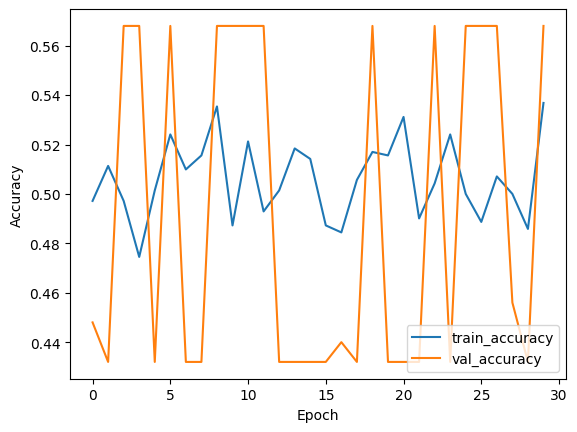

In [140]:
# Plot training history to check for overfitting or underfitting
import matplotlib.pyplot as plt

plt.plot(history2.history['accuracy'], label='train_accuracy')
plt.plot(history2.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()